# Aquifer Storage and Recovery with MODFLOW6 and Flopy

In this notebook, we will learn how to:
1. Simulate both injection and recovery of freshwater with a well (radial flow).
2. Create animation with slider
3. Compute the mass balance and the recovery efficiency
4. Perform two cycles

In [1]:
# import the necessary packages
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (5, 3) # set default figure size
import flopy as fp  # import flopy and call it fp

## Description of the flow problem
Consider radial flow in a confined aquifer. The aquifer extends in the $r$ direction from $r=0$ to $r=R$, where $R$ is chosen far enough away not to effect the solution.  Water is injected by the well at a rate $Q$. The head is fixed at $r=R$ to $h_R$. Flow is considered to be at steady state instantaneously. 

The initial salt concentration is equal to $c_s$ everywhere. Injection of fresh water with concentration $c_f$ starts at $t=0$ and last for $t_\text{in}$ days, after which water is extracted at the same rate $Q$ for $t_\text{out}$ days.

The parameter block is similar to the parameter block for one-dimensional (linear) flow. Some values are chosen differently, such as the time of injection. The values of the hydraulic conductivity and porosity are converted so that MODFLOW can be used to simulate radial flow (see Langevin, 2008).

In [2]:
# domain size and boundary conditions
R = 80 # length of domain, m
hR = 0 # head at r=R

# aquifer parameters
k = 20 # hydraulic conductivity, m/d
H = 20 # aquifer thickness, m
npor = 0.35 # porosity, -

# flow
Q = 500 # injection and extraction rate, m^3/d

# transport
alphaL = 0.5 # longitudinal dispersivity in horizontal direction, m
alphaT = alphaL / 10 # transverse dispersivity in horizontal direction, m
diffusion_coef = 0 # diffusion coeffcient

# concentration
cs = 35 # initial concentration, kg/m^3 (=g/L)
cf = 0 # concentration injected water, kg/m^3 (=g/L)

# space discretization
delr = 0.2 # length of cell along row (in x-direction), m
delc = 1 # width of cells normal to plane of flow (in y-direction), m
z = [0, -H] # top and bottom(s) of layers
nlay = 1 # number of layers
nrow = 1 # number of rows
ncol = round(R / delr) # number of columns
rw = 0.2 # radius of well, m
r = rw + np.cumsum(delr * np.ones(ncol)) - 0.5 * delr # radial coordinates of centers of cells, m

# convert parameters for radial flow following procedure of Langevin, 2008
theta = 2 * np.pi # angle for full circle
krad = k * r * theta # convert k for radial flow
nporrad = npor * r * theta # convert porosity for radial flow

# time discretization
tin = 30 # injection time, d
delt = 0.1 # time step, d
nstepin = round(tin / delt) # computed number of steps during injection, integer
tout = 30 # extraction time, d
delt = 0.1 # time step, d
nstepout = round(tout / delt) # computed number of steps during extraction, integer

# model name and workspace
modelname = 'modelrad' # name of model
gwfname = modelname + 'f' # name of flow model
gwtname = modelname + 't' # name of transport model
modelws = './' + modelname # model workspace to be used

## Create Simulation
No changes need to be made.

In [3]:
# simulation
sim = fp.mf6.MFSimulation(sim_name=modelname, # name of simulation
                          version='mf6', # version of MODFLOW
                          exe_name='../bin/mf6', # absolute path to MODFLOW executable
                          sim_ws=modelws, # path to workspace where all files are stored
                         )

# time discretization
tdis = fp.mf6.ModflowTdis(simulation=sim, # add to the simulation called sim (defined above)
                          time_units="DAYS", 
                          nper=2, # number of stress periods 
                          perioddata=[[tin, nstepin, 1],
                                      [tout, nstepout, 1]], # period length, number of steps, timestep multiplier
                         )

## Create groundwater flow model (`gwf`)
Changes in the groundwater flow model:
* Use the converted value of $k$ in the npf package and use the logarithmic averaging option to compute cell-by-cell hydraulic conductivities.
* Use the discharge $Q$ in the well package.

In [4]:
# groundwater flow model
gwf = fp.mf6.ModflowGwf(simulation=sim, # add to simulation called sim
                        modelname=gwfname, # name of gwf model
                        save_flows=True, # make sure all flows are stored in binary output file
                       )

# iterative model solver
gwf_ims  = fp.mf6.ModflowIms(simulation=sim, # add to simulation called sim
                             filename=gwf.name + '.ims', # file name to store ims
                             linear_acceleration="BICGSTAB", # use BIConjuGantGradientSTABalized method
                            )                                                                                                
# register solver
sim.register_ims_package(solution_file=gwf_ims, # name of iterative model solver instance
                         model_list=[gwf.name], # list with name of groundwater flow model
                        )   

# discretization
gwf_dis = fp.mf6.ModflowGwfdis(model=gwf, # add to groundwater flow model called gwf
                               nlay=nlay, 
                               nrow=nrow, 
                               ncol=ncol, 
                               delr=delr, 
                               delc=delc, 
                               top=z[0], 
                               botm=z[1:], 
                              )

# aquifer properties
gwf_npf  = fp.mf6.ModflowGwfnpf(model=gwf, 
                                k=krad, # horizontal k value
                                alternative_cell_averaging="LOGARITHMIC", # logarithmic averaging
                                save_flows=True, # save the flow for all cells
                               )
    
# initial condition
gwf_ic = fp.mf6.ModflowGwfic(model=gwf, 
                             strt=hR, # initial head used for iterative solution
                            )

# wells
wellin = [[(0, 0, 0),  Q, cf]]   # [(layer, row, col), U, concentration]
wellout = [[(0, 0, 0),  -Q, cf]] # specified concentration is not used, but must be specified 
wel_spd = {0: wellin, 1: wellout} # stress period data for periods 0 and 1
gwf_wel = fp.mf6.ModflowGwfwel(model=gwf, 
                               stress_period_data=wel_spd, 
                               auxiliary=['CONCENTRATION'],
                               pname='WEL1', # package name
                              )

# constant head 
chd0 = [[(0,  0,  ncol-1), hR, cs]] # [(layer, row, col), head, concentration]
chd_spd  = {0: chd0}    # Stress period data
gwf_chd = fp.mf6.ModflowGwfchd(model=gwf, 
                               stress_period_data=chd_spd, 
                               auxiliary=['CONCENTRATION'],
                               pname='CHD1', # package name
                              )
    
# output control
oc = fp.mf6.ModflowGwfoc(model=gwf, 
                         saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")], # what to save
                         budget_filerecord=f"{gwfname}.cbc", # file name where all budget output is stored
                         head_filerecord=f"{gwfname}.hds", # file name where all head output is stored
                        )

## Create groundwater transport model (`gwt`)
Changes in the transport model: Use the converted value of the porosity in the mst package.

In [5]:
# groundwater transport model
gwt = fp.mf6.ModflowGwt(simulation=sim, 
                        modelname=gwtname, # name of groundwater transport model
                       )

# iterative model solver
gwt_ims  = fp.mf6.ModflowIms(simulation=sim,
                             filename=gwt.name + '.ims', # must be different than file name of gwf model ims
                             linear_acceleration="BICGSTAB",
                            ) 
sim.register_ims_package(solution_file=gwt_ims, 
                         model_list=[gwt.name],
                        )

# discretization
gwt_dis = fp.mf6.ModflowGwtdis(model=gwt, 
                               nlay=nlay, 
                               nrow=nrow, 
                               ncol=ncol, 
                               delr=delr, 
                               delc=delc, 
                               top=z[0], 
                               botm=z[1:], 
                              )

# mobile storage and transfer
gwt_sto = fp.mf6.ModflowGwtmst(model=gwt, 
                               porosity=nporrad, # porosity
                               save_flows=True,
                              )

# initial condition
gwt_ic = fp.mf6.ModflowGwtic(model=gwt, 
                             strt=cs, # initial concentration
                            ) 

# source sink mixing
sourcelist = [("WEL1", "AUX", "CONCENTRATION"), ("CHD1", "AUX", "CONCENTRATION")]
ssm = fp.mf6.ModflowGwtssm(model=gwt, 
                           sources=sourcelist, 
                           save_flows=True,
                           pname='SSM1', 
                          )

# advection
adv = fp.mf6.ModflowGwtadv(model=gwt,  
                           scheme="TVD",  # use Total Variation Diminishing (TVD)
                           pname='ADV1',
                          )

# dispersion
dsp = fp.mf6.ModflowGwtdsp(model=gwt, 
                           alh=alphaL,
                           ath1=alphaT, 
                           diffc=diffusion_coef,
                           pname='DSP1', 
                          )

# output control
oc = fp.mf6.ModflowGwtoc(model=gwt,
                         saverecord=[("CONCENTRATION", "ALL"), ("BUDGET", "ALL")], # what to save
                         budget_filerecord=f"{gwtname}.cbc", # file name where all budget output is stored
                         concentration_filerecord=f"{gwtname}.ucn", # file name where all concentration output is stored
                        )

Changes in interaction: None

In [6]:
fp.mf6.ModflowGwfgwt(simulation=sim, 
                     exgtype="GWF6-GWT6", 
                     exgmnamea=gwf.name , 
                     exgmnameb=gwt.name , 
                     filename=f"{modelname}.gwfgwt",
                    );

## Write input files and solve model

In [7]:
sim.write_simulation(silent=True)
success, _ = sim.run_simulation(silent=True) 
if success == 1:
    print('Model solved successfully')
else:
    print('Solve failed')

Model solved successfully


## Read and plot heads and compare to exact solution
The exact solution is
\begin{equation}
h = -\frac{Q}{2\pi kH}\ln(r/R)
\end{equation}

In [8]:
hds = gwf.output.head() # get handle to binary head file
head = hds.get_alldata().squeeze() # get the head data from the file

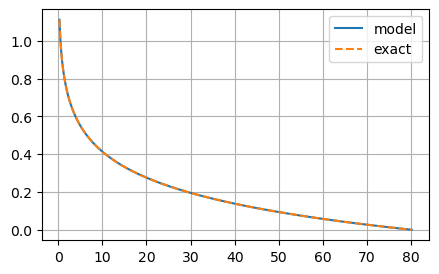

In [9]:
plt.plot(r, head[0], label='model')
hexact = -Q / (2 * np.pi * k * H) * np.log(r / r[-1])
plt.plot(r, hexact, '--', label='exact')
plt.legend()
plt.grid()

## Read concentration data and make (interactive) plot

Plot the concentration vs. $r$ at 10 day intervals. Make separate plots for the injection and extraction periods.

In [10]:
cobj = gwt.output.concentration() # get handle to binary concentration file
c = cobj.get_alldata().squeeze() # get the concentration data from the file
times = np.array(cobj.get_times()) # get the times and convert to array

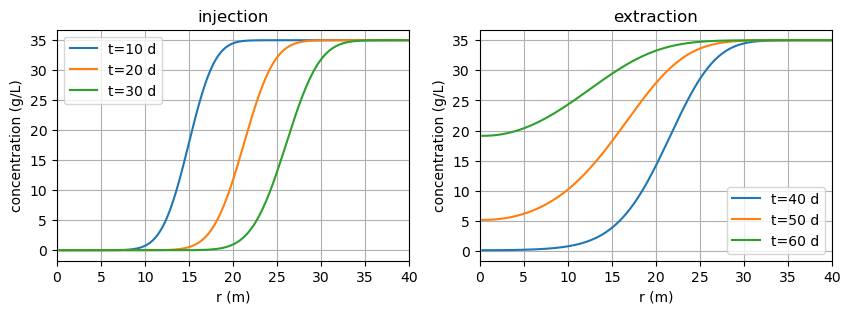

In [11]:
# plot concentration vs. x for three different times   
plt.figure(figsize=(10, 3))
plt.subplot(121)
for t in np.arange(10, 31, 10):
    itime = np.abs(times - t).argmin() # find index of value in times closest to t
    plt.plot(r, c[itime,:], label=f't={times[itime]:.0f} d')
plt.title('injection')
plt.xlabel('r (m)')
plt.ylabel('concentration (g/L)')
plt.xlim(0, 40)
plt.legend()
plt.grid()
plt.subplot(122)
for t in np.arange(40, 61, 10):
    itime = np.abs(times - t).argmin() # find index of value in times closest to t
    plt.plot(r, c[itime,:], label=f't={times[itime]:.0f} d')
plt.title('extraction')
plt.xlabel('r (m)')
plt.ylabel('concentration (g/L)')
plt.xlim(0, 40)
plt.legend()
plt.grid()

## Interactive plot of concentration

In [12]:
from ipywidgets import interact

def plot(tstep):
    plt.subplot(111, xlim=(0, 60), ylim=(0, 35), xlabel='r (m)', ylabel='concentration (g/L)')
    plt.plot(r, c[tstep])

interact(plot, tstep=(0, 2 * nstepin - 1, 1));

C:\Users\924878\AppData\Local\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\924878\AppData\Local\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\924878\AppData\Local\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\924878\AppData\Local\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:528: DeprecationWar

interactive(children=(IntSlider(value=299, description='tstep', max=599), Output()), _dom_classes=('widget-int…

## Mass balance
During an injection time step, freshwater with concentration $c_f$ flows into the system at a rate $Q$, while saltwater with concentration $c_s$ flows out of the system at a rate $Q$ (recall that flow is stationary). Hence, the change in mass of salt $\Delta M_1$ (positive for an increase in mass) in the system during a time step is \begin{equation}
\Delta M_1 = (Q c_f - Q c_s)\Delta t
\end{equation}
During an extraction time sep, the mass increase is
\begin{equation}
\Delta M_1 = (-Q c_0 + Q c_s)\Delta t
\end{equation}
If the mass balance is met, this change in mass must be equal to the change in mass in the system $\Delta M_2$
\begin{equation}
\Delta M_2 = \sum_i{(c_i(t)-c_i(t-\Delta t)) (r_{i+1}^2 - r_{i}^2) \pi H n\Delta x}
\end{equation}
where $r_i$ is the radial distance of the left side of cell $i$. 
The mass balance is computed for one time step as follows 

## Recovery efficiency
The recovery efficiency is computed using $c_\text{limit}=1$ kg/m$^3$ (g/L) as follows

In [13]:
climit = 1 # limit concentration, g/L

In [14]:
for itime in range(400, 800):
    if c[itime, 0] > climit:
        break
print(f'first time when c exceeds climit: {round(times[itime], 2)} d when concentration is {c[itime, 0]:.2f} g/L')

rec_eff = ((times[itime - 1] - tin) * Q) / (tin * Q) # Q not needed as injection and extraction rates are the same
print(f'recovery efficiency = {rec_eff * 100:.1f} %')

first time when c exceeds climit: 44.4 d when concentration is 1.03 g/L
recovery efficiency = 47.7 %


## Two cycles
The recovery efficiency generally improves with more cycles. In the code block below, two cycles are performed. Extraction during the first cycle is stopped when the concentration in the well reaches $c_\text{limit}$. The concentration at the end of the first cycle is used as the initial condition of the second cycle. 

In [15]:
# initial condition
gwt_ic = fp.mf6.ModflowGwtic(model=gwt, 
                             strt=cs, # initial concentration
                            ) 

# write model, solve model, and read concentration data
sim.write_simulation(silent=True)
success, _ = sim.run_simulation(silent=True) 
if success == 1:
    print('Model solved successfully')
else:
    print('Solve failed')

cobj = gwt.output.concentration() # get handle to binary concentration file
c0 = cobj.get_alldata().squeeze() # get the concentration data from the file

for itime in range(400, 800):
    if c0[itime, 0] > climit:
        itime0 = itime
        break

rec_eff = ((times[itime - 1] - tin) * Q) / (tin * Q) # U not needed as injection and extraction rates are the same
print(f'recovery efficiency = {rec_eff * 100:.1f} %')

# initial condition
gwt_ic = fp.mf6.ModflowGwtic(model=gwt, 
                             strt=c0[itime - 1], # initial concentration
                            ) 

# write model, solve model, and read concentration data
sim.write_simulation(silent=True)
success, _ = sim.run_simulation(silent=True) 
if success == 1:
    print('Model solved successfully')
else:
    print('Solve failed')

cobj = gwt.output.concentration() # get handle to binary concentration file
c1 = cobj.get_alldata().squeeze() # get the concentration data from the file

for itime in range(400, 800):
    if c1[itime, 0] > climit:
        itime1 = itime
        break

rec_eff = ((times[itime - 1] - tin) * Q) / (tin * Q) # U not needed as injection and extraction rates are the same
print(f'recovery efficiency = {rec_eff * 100:.1f} %')

Model solved successfully
recovery efficiency = 47.7 %
Model solved successfully
recovery efficiency = 70.3 %


All concentrations are put into one array that is then used for plotting. 

In [16]:
# gather all concentration in one array
c0[itime0:] = c0[itime0 - 1]
c1[itime1:] = c1[itime1 - 1]
cplot = np.vstack((c0, c1))

In [17]:
from ipywidgets import interact

def plot(tstep):
    plt.subplot(111, xlim=(0, 60), ylim=(0, 35), xlabel='r (m)', ylabel='concentration (g/L)')
    plt.plot(r, cplot[tstep])

interact(plot, tstep=(0, 4 * nstepin - 1, 1));

C:\Users\924878\AppData\Local\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\924878\AppData\Local\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\924878\AppData\Local\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\924878\AppData\Local\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:528: DeprecationWar

interactive(children=(IntSlider(value=599, description='tstep', max=1199), Output()), _dom_classes=('widget-in…

## Homework
Use the parameters defined in the code block at the beginning of this notebook.

### Problem 1
Simulate one cycle.
Plot the change in mass during the entire cycle vs. the time step. Plot both $\Delta M1$ and $\Delta M2$ in one graph. Don't forget to add a legend.

### Problem 2
Compute the recovery efficiency for the first five cycles and plot the recovery efficiency vs. the cycle number in one graph. You must use a loop to perform the five cycles. 

Model solved successfully
Recovery efficiency for cycle 1 = 70.3 %
Model solved successfully
Recovery efficiency for cycle 2 = 70.3 %
Model solved successfully
Recovery efficiency for cycle 3 = 70.3 %
Model solved successfully
Recovery efficiency for cycle 4 = 70.3 %
Model solved successfully
Recovery efficiency for cycle 5 = 70.3 %


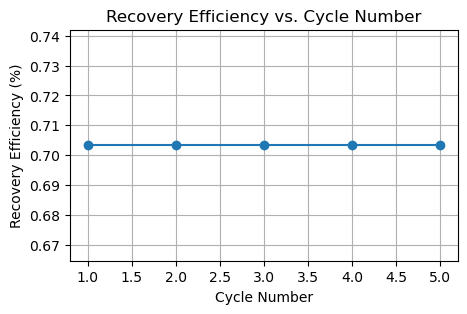

In [19]:
# Number of cycles
num_cycles = 5

# Arrays to store recovery efficiencies for each cycle
cycle_numbers = []
recovery_efficiencies = []

for cycle in range(1, num_cycles + 1):
    # initial condition
    gwt_ic = fp.mf6.ModflowGwtic(model=gwt, strt=c0[itime - 1])

    # write model, solve model, and read concentration data
    sim.write_simulation(silent=True)
    success, _ = sim.run_simulation(silent=True)
    if success == 1:
        print('Model solved successfully')
    else:
        print('Solve failed')

    cobj = gwt.output.concentration()
    c = cobj.get_alldata().squeeze()

    # Find the time step when concentration exceeds climit
    for itime in range(400, 800):
        if c[itime, 0] > climit:
            break

    rec_eff = ((times[itime - 1] - tin) * Q) / (tin * Q)
    print(f'Recovery efficiency for cycle {cycle} = {rec_eff * 100:.1f} %')

    # Store results for plotting
    cycle_numbers.append(cycle)
    recovery_efficiencies.append(rec_eff)

    # Update initial condition for the next cycle
    gwt_ic.strt = c[itime - 1]

# Plot the results
plt.plot(cycle_numbers, recovery_efficiencies, marker='o')
plt.xlabel('Cycle Number')
plt.ylabel('Recovery Efficiency (%)')
plt.title('Recovery Efficiency vs. Cycle Number')
plt.grid(True)
plt.show()